<h1 style="text-align:center;">Data Science & Society Thesis</h1>
<h3 style="text-align:center;">FORECASTING CRYPTO PRICE  PEAKS: REGRESSION – BASED </h3>
<h3 style="text-align:center;">TIME – UNTIL – NEW - HIGH </h3>
<h3 style="text-align:center;">PREDICTIONS</h3>
<h5 style="text-align:center;"> ELEFTHERIOS DIAMANTIDIS</h5>

---

# **RQ 1:** ML Model Comparison

## <span style='color:brown'>**Stage A:** Preprocessing</span>

### **Step 1:** Import Libraries

In [137]:
# Import Basic Libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pylab as plt   
import matplotlib.dates as mdates                                                            
import seaborn as sns                                                                        
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Prevent line-wrapping

import statsmodels.api as sm
from collections import Counter
from scipy.stats import randint, uniform, loguniform

import shap

from plot_results import plot_log_results, plot_results

# Import Libraries for Time Series Analysis
from tsfresh import extract_features, select_features                                        
from tsfresh.utilities.dataframe_functions import roll_time_series, impute                   

# Import Libraries for Machine Learning
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score          
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit                      
from sklearn.preprocessing import StandardScaler, RobustScaler                 
from sklearn.svm import SVR                                                                  
from sklearn.ensemble import RandomForestRegressor         
from quantile_forest import RandomForestQuantileRegressor
from xgboost import XGBRegressor
                                                                        

# Import Libraries for Deep Learning
from tensorflow.keras.models import Sequential, Model                                               
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam                                                 
from scikeras.wrappers import KerasRegressor                                                                       
from keras_tuner import RandomSearch   
from tensorflow.keras.optimizers import Nadam                                               
from keras.callbacks import EarlyStopping      
import kerastuner as kt  
from keras.regularizers import l2

### **Step 2:** Import data

In [138]:
df_aave = pd.read_csv("data/final_data_aave.csv")
df_aave['coin'] = 'AAVE'
df_aave = df_aave.rename(columns={"Date":"date"})
df_aave["date"] = pd.to_datetime(df_aave["date"])
df_aave['Date'] = df_aave['date'].dt.date
df_aave['date'] = df_aave['date'].dt.date
df_aave = df_aave.set_index('Date')
print(df_aave.head())

                  date       Open       High        Low      Close  Volume  tunh  coin
Date                                                                                  
2020-10-02  2020-10-02   0.000000   0.516571   0.000000   0.516571       0   1.0  AAVE
2020-10-03  2020-10-03   0.523836  65.305939   0.523801  53.151489       0  38.0  AAVE
2020-10-04  2020-10-04  53.179859  55.070354  50.688992  52.675034       0   1.0  AAVE
2020-10-05  2020-10-05  52.675034  55.112358  49.787899  53.219242       0   8.0  AAVE
2020-10-06  2020-10-06  53.291969  53.402271  40.734577  42.401600  583091   6.0  AAVE


In [139]:
df_aave.shape

(1651, 8)

### **Step 3:** Handle missing data & outliers

In [140]:
df_aave.isna().sum()

date       0
Open       0
High       0
Low        0
Close      0
Volume     0
tunh      36
coin       0
dtype: int64

In [141]:
df_aave['tunh'] = df_aave['tunh'].ffill().bfill()

In [142]:
df_aave.isna().sum()

date      0
Open      0
High      0
Low       0
Close     0
Volume    0
tunh      0
coin      0
dtype: int64

In [143]:
upper_limit = df_aave['tunh'].quantile(0.99)
df_aave['tunh_outlier'] = df_aave['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_aave['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_aave):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 17 outliers (1.03%) above the 99th percentile (929.50 days).


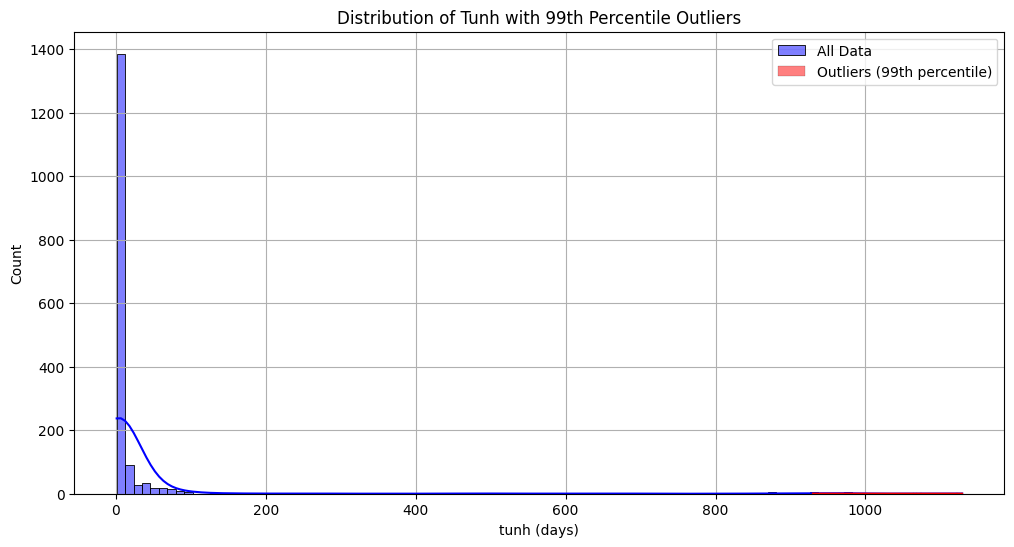

In [144]:
plt.figure(figsize=(12, 6))
sns.histplot(df_aave['tunh'], bins=100, kde=True, color='blue', label='All Data')
sns.histplot(df_aave[df_aave['tunh_outlier']]['tunh'], bins=100, kde=True, color='red', label='Outliers (99th percentile)')
plt.xlabel("tunh (days)")
plt.title("Distribution of Tunh with 99th Percentile Outliers")
plt.legend()
plt.grid(True)
plt.show()

In [145]:
df_aave = df_aave[~df_aave['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_aave.shape}")
df_aave.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (1634, 9)


### **Step 4:** Log-transform target

In [146]:
df_aave['tunh_log'] = np.log1p(df_aave['tunh'])
print(df_aave.head())

                  date       Open       High        Low      Close  Volume  tunh  coin  tunh_log
Date                                                                                            
2020-10-02  2020-10-02   0.000000   0.516571   0.000000   0.516571       0   1.0  AAVE  0.693147
2020-10-03  2020-10-03   0.523836  65.305939   0.523801  53.151489       0  38.0  AAVE  3.663562
2020-10-04  2020-10-04  53.179859  55.070354  50.688992  52.675034       0   1.0  AAVE  0.693147
2020-10-05  2020-10-05  52.675034  55.112358  49.787899  53.219242       0   8.0  AAVE  2.197225
2020-10-06  2020-10-06  53.291969  53.402271  40.734577  42.401600  583091   6.0  AAVE  1.945910


### **Step 5:** Plots

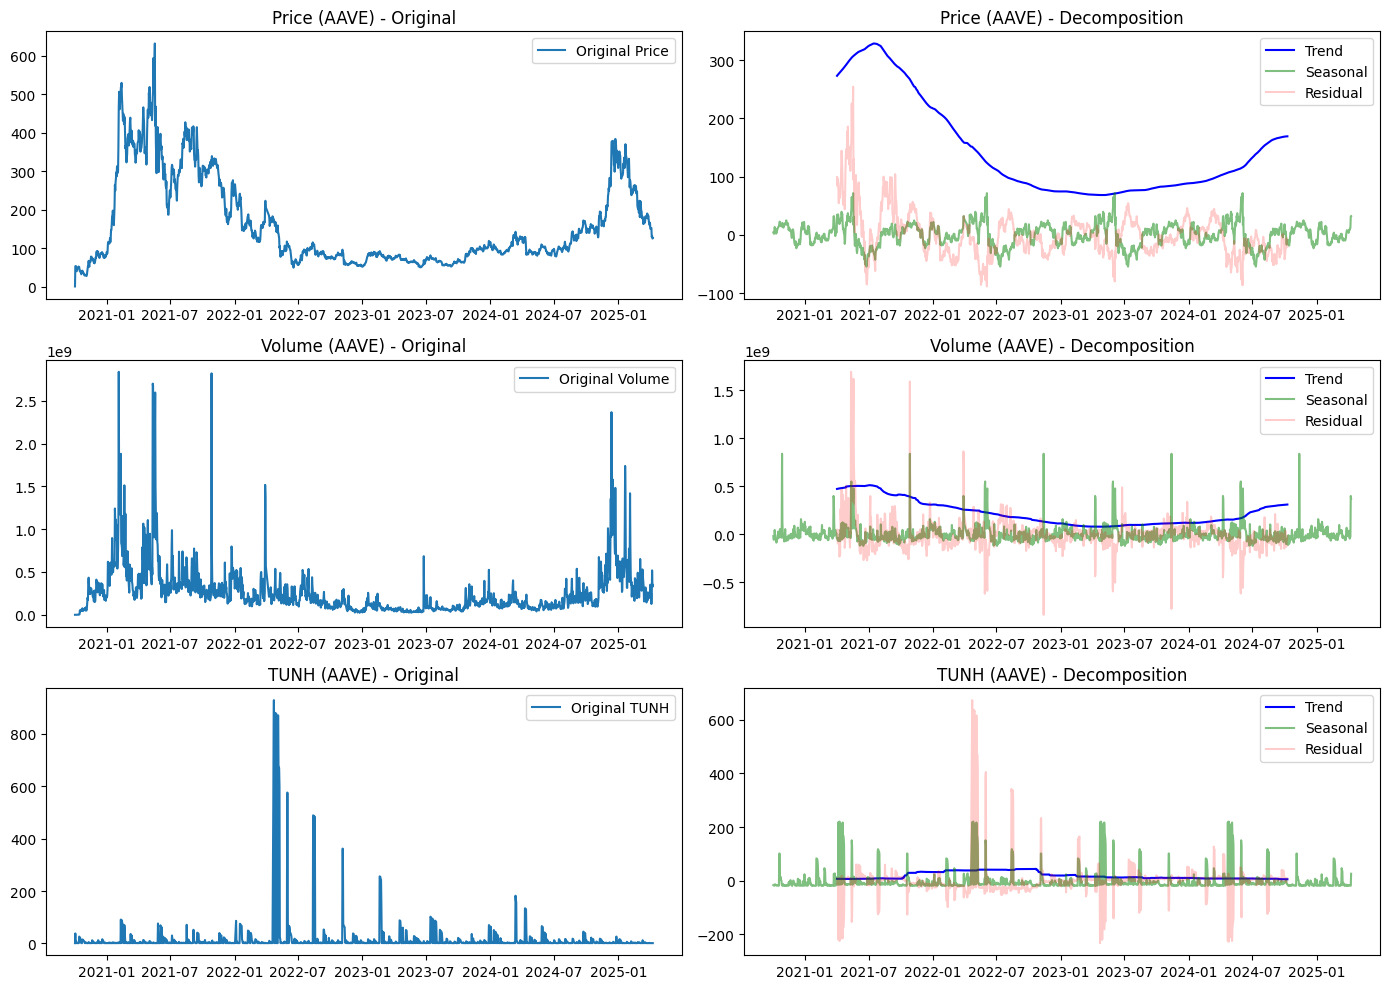

In [147]:
# Decompose the time series for 'Close', 'Volume', and 'tunh'
decomposition_price = sm.tsa.seasonal_decompose(df_aave['Close'], model='additive', period=365)
decomposition_volume = sm.tsa.seasonal_decompose(df_aave['Volume'], model='additive', period=365)
decomposition_tunh = sm.tsa.seasonal_decompose(df_aave['tunh'], model='additive', period=365)

# Create the subplots for Price, Volume, and TUNH
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Price (Close)
axes[0, 0].plot(df_aave['Close'], label='Original Price')
axes[0, 0].set_title('Price (AAVE) - Original')
axes[0, 0].legend()

axes[0, 1].plot(decomposition_price.trend, label='Trend', color='blue')
axes[0, 1].plot(decomposition_price.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[0, 1].plot(decomposition_price.resid, label='Residual', color='red', alpha=0.2)
axes[0, 1].set_title('Price (AAVE) - Decomposition')
axes[0, 1].legend()

# Volume
axes[1, 0].plot(df_aave['Volume'], label='Original Volume')
axes[1, 0].set_title('Volume (AAVE) - Original')
axes[1, 0].legend()

axes[1, 1].plot(decomposition_volume.trend, label='Trend', color='blue')
axes[1, 1].plot(decomposition_volume.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[1, 1].plot(decomposition_volume.resid, label='Residual', color='red', alpha=0.2)
axes[1, 1].set_title('Volume (AAVE) - Decomposition')
axes[1, 1].legend()

# TUNH
axes[2, 0].plot(df_aave['tunh'], label='Original TUNH')
axes[2, 0].set_title('TUNH (AAVE) - Original')
axes[2, 0].legend()

axes[2, 1].plot(decomposition_tunh.trend, label='Trend', color='blue')
axes[2, 1].plot(decomposition_tunh.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[2, 1].plot(decomposition_tunh.resid, label='Residual', color='red', alpha=0.2)
axes[2, 1].set_title('TUNH (AAVE) - Decomposition')
axes[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

fig.savefig('Plots/1. time_series_plots/5. decomposition_aave.png', dpi=300, bbox_inches='tight')

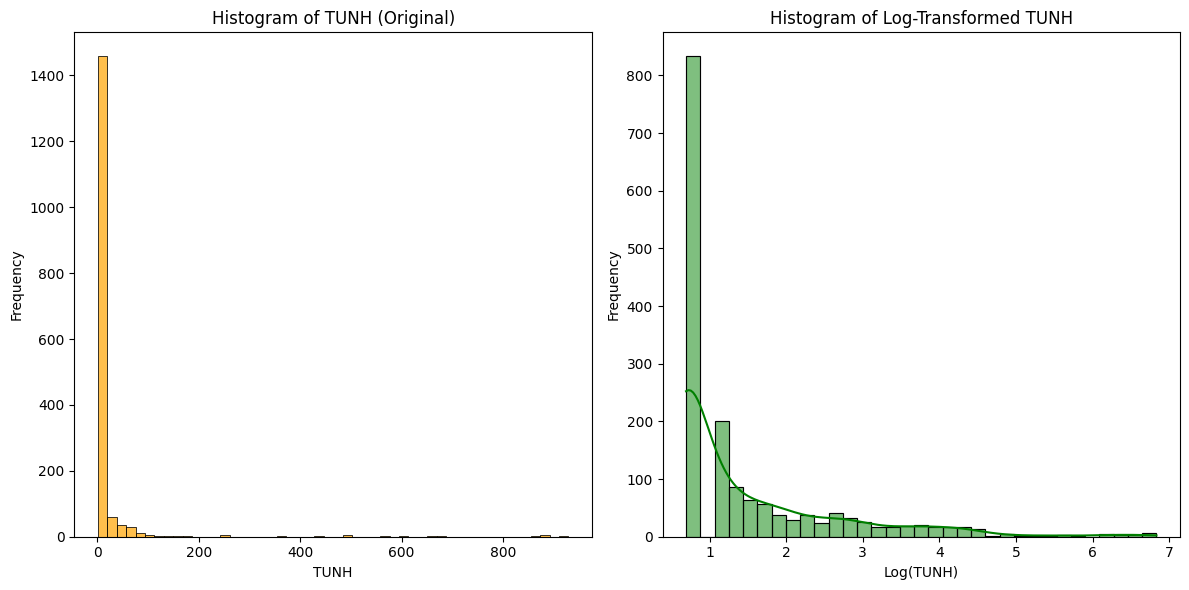

In [148]:
# Plot histogram for TUNH
plt.figure(figsize=(12, 6))

# Plot original TUNH histogram
plt.subplot(1, 2, 1)
sns.histplot(df_aave['tunh'], bins=50, color='orange', edgecolor="black", alpha=0.7)  # default Matplotlib colours
plt.title('Histogram of TUNH (Original)')
plt.xlabel('TUNH')
plt.ylabel('Frequency')

# Plot transformed TUNH (log-transformed) histogram
plt.subplot(1, 2, 2)
sns.histplot(df_aave['tunh_log'], kde=True, color='green')
plt.title('Histogram of Log-Transformed TUNH')
plt.xlabel('Log(TUNH)')
plt.ylabel('Frequency')

# Show the plots
plt.savefig('Plots/2. histograms/5. histogram_aave.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

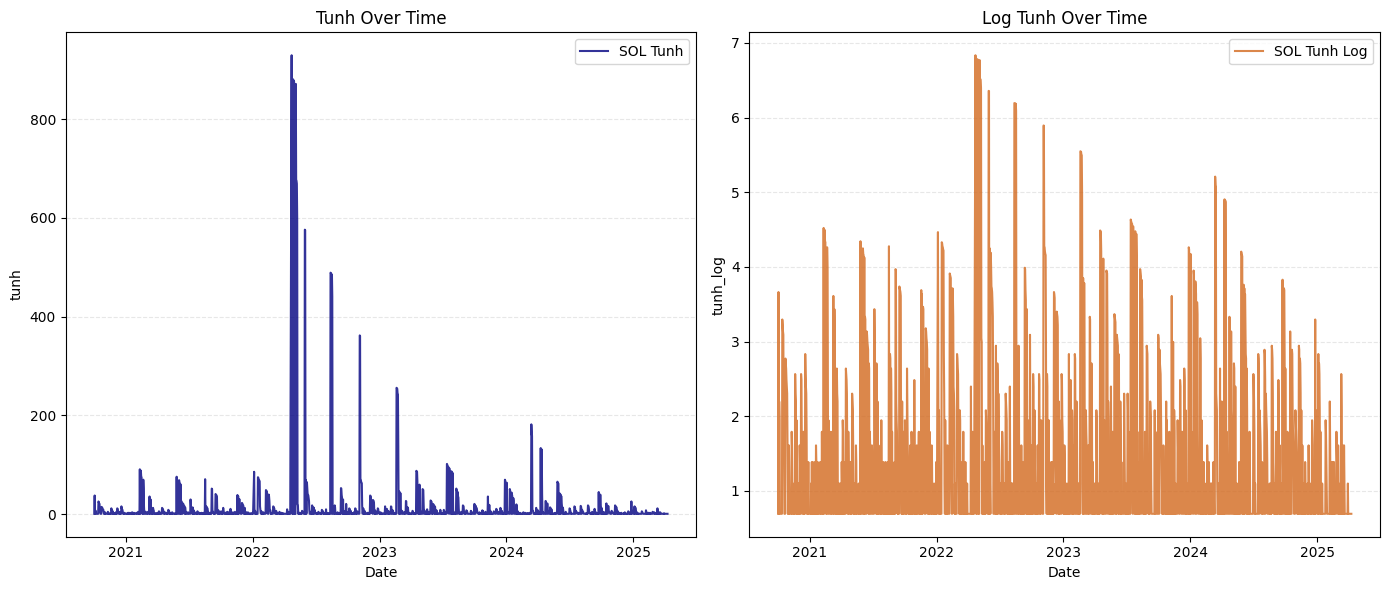

In [149]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tunh Over Time
sns.lineplot(x=df_aave["date"], y=df_aave["tunh"], color="navy", alpha=0.8, label="SOL Tunh", ax=axes[0])
axes[0].set_title("Tunh Over Time")
axes[0].set_xlabel('Date')
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].set_ylabel('tunh')
axes[0].legend()
axes[0].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[0].grid(visible=False, alpha=0.0, axis='x')

# Second plot: Log Tunh Over Time
sns.lineplot(x=df_aave["date"], y=df_aave["tunh_log"], color="chocolate", alpha=0.8, label="SOL Tunh Log", ax=axes[1])
axes[1].set_title("Log Tunh Over Time")
axes[1].set_xlabel('Date')
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].set_ylabel('tunh_log')
axes[1].legend()
axes[1].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[1].grid(visible=False, alpha=0.0, axis='x')

plt.savefig('Plots/3. lineplots/5. lineplot_aave.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

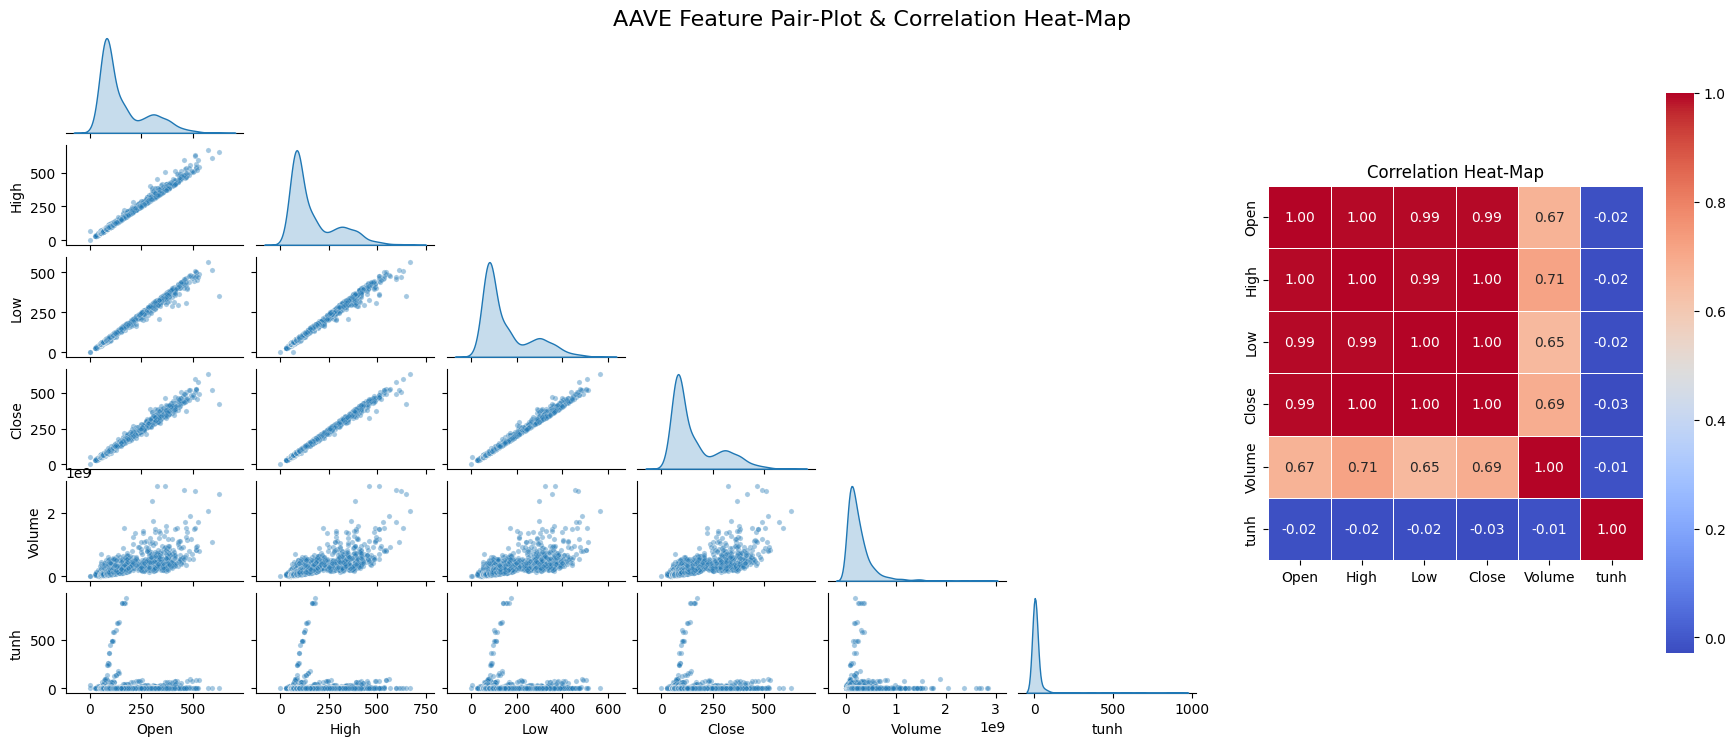

In [150]:
num_cols = ["Open", "High", "Low", "Close", "Volume", "tunh"]

g = sns.pairplot(
    df_aave[num_cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 14}
)
g.fig.set_size_inches(18, 7)          # make it wide enough

g.fig.subplots_adjust(right=0.68)     # 68 % of width → pair‑plot; rest → heat‑map

ax_heat = g.fig.add_axes([0.72, 0.10, 0.26, 0.80])   # [left, bottom, width, height]

corr = df_aave[num_cols].corr(method="pearson")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    ax=ax_heat
)
ax_heat.set_title("Correlation Heat‑Map", fontsize=12)

g.fig.suptitle("AAVE Feature Pair‑Plot & Correlation Heat‑Map", y=1.02, fontsize=16)
plt.savefig('Plots/4. pairplots/5. pairplot_aave.png', dpi=300, bbox_inches='tight')
plt.show()

In [151]:
df_aave = df_aave.drop(['tunh'], axis=1)

### **Step 6:** Function to calculate metrics

In [152]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    da = np.mean(direction_true == direction_pred) * 100
    return mae, rmse, mape, da

### **Step 7:** Convert to time-series

In [153]:
df_aave_rolled = roll_time_series(df_aave, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


In [154]:
print(df_aave_rolled.head())
print("\nLen of df_rolled:",len(df_aave_rolled))
print("Unique id's:",df_aave_rolled["id"].nunique())

         date       Open       High        Low      Close  Volume  coin  tunh_log                  id
0  2020-10-02   0.000000   0.516571   0.000000   0.516571       0  AAVE  0.693147  (AAVE, 2020-10-07)
1  2020-10-03   0.523836  65.305939   0.523801  53.151489       0  AAVE  3.663562  (AAVE, 2020-10-07)
2  2020-10-04  53.179859  55.070354  50.688992  52.675034       0  AAVE  0.693147  (AAVE, 2020-10-07)
3  2020-10-05  52.675034  55.112358  49.787899  53.219242       0  AAVE  2.197225  (AAVE, 2020-10-07)
4  2020-10-06  53.291969  53.402271  40.734577  42.401600  583091  AAVE  1.945910  (AAVE, 2020-10-07)

Len of df_rolled: 34089
Unique id's: 1629


### **Step 8:** Feature extraction

In [155]:
X = extract_features(df_aave_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


### **Step 9:** Split the data

In [156]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,tunh_log__variance_larger_than_standard_deviation,tunh_log__has_duplicate_max,tunh_log__has_duplicate_min,tunh_log__has_duplicate,tunh_log__sum_values,tunh_log__abs_energy,tunh_log__mean_abs_change,tunh_log__mean_change,tunh_log__mean_second_derivative_central,tunh_log__median,tunh_log__mean,tunh_log__length,tunh_log__standard_deviation,tunh_log__variation_coefficient,tunh_log__variance,tunh_log__skewness,tunh_log__kurtosis,tunh_log__root_mean_square,tunh_log__absolute_sum_of_changes,tunh_log__longest_strike_below_mean,tunh_log__longest_strike_above_mean,tunh_log__count_above_mean,tunh_log__count_below_mean,tunh_log__last_location_of_maximum,tunh_log__first_location_of_maximum,tunh_log__last_location_of_minimum,tunh_log__first_location_of_minimum,tunh_log__percentage_of_reoccurring_values_to_all_values,tunh_log__percentage_of_reoccurring_datapoints_to_all_datapoints,tunh_log__sum_of_reoccurring_values,tunh_log__sum_of_reoccurring_data_points,tunh_log__ratio_value_number_to_time_series_length,tunh_log__sample_entropy,tunh_log__maximum,tunh_log__absolute_maximum,tunh_log__minimum,tunh_log__benford_correlation,tunh_log__time_reversal_asymmetry_statistic__lag_1,tunh_log__time_reversal_asymmetry_statistic__lag_2,tunh_log__time_reversal_asymmetry_statistic__lag_3,tunh_log__c3__lag_1,tunh_log__c3__lag_2,tunh_log__c3__lag_3,tunh_log__cid_ce__normalize_True,tunh_log__cid_ce__normalize_False,tunh_log__symmetry_looking__r_0.0,tunh_log__symmetry_looking__r_0.05,tunh_log__symmetry_looking__r_0.1,tunh_log__symmetry_looking__r_0.15000000000000002,tunh_log__symmetry_looking__r_0.2,tunh_log__symmetry_looking__r_0.25,tunh_log__symmetry_looking__r_0.30000000000000004,tunh_log__symmetry_looking__r_0.35000000000000003,tunh_log__symmetry_looking__r_0.4,tunh_log__symmetry_looking__r_0.45,tunh_log__symmetry_looking__r_0.5,tunh_log__symmetry_looking__r_0.55,tunh_log__symmetry_looking__r_0.6000000000000001,tunh_log__symmetry_looking__r_0.65,tunh_log__symmetry_looking__r_0.7000000000000001,tunh_log__symmetry_looking__r_0.75,tunh_log__symmetry_looking__r_0.8,tunh_log__symmetry_looking__r_0.8500000000000001,tunh_log__symmetry_looking__r_0.9,tunh_log__symmetry_looking__r_0.9500000000000001,tunh_log__large_standard_deviation__r_0.05,tunh_log__large_standard_deviation__r_0.1,tunh_log__large_standard_deviation__r_0.15000000000000002,tunh_log__large_standard_deviation__r_0.2,tunh_log__large_standard_deviation__r_0.25,tunh_log__large_standard_deviation__r_0.30000000000000004,tunh_log__large_standard_deviation__r_0.35000000000000003,tunh_log__large_standard_deviation__r_0.4,tunh_log__large_standard_deviation__r_0.45,tunh_log__large_standard_deviation__r_0.5,tunh_log__large_standard_deviation__r_0.55,tunh_log__large_standard_deviation__r_0.6000000000000001,tunh_log__large_standard_deviation__r_0.65,tunh_log__large_standard_deviation__r_0.7000000000000001,tunh_log__large_standard_deviation__r_0.75,tunh_log__large_standard_deviation__r_0.8,tunh_log__large_standard_deviation__r_0.8500000000000001,tunh_log__large_standard_deviation__r_0.9,tunh_log__large_standard_deviation__r_0.9500000000000001,tunh_log__quantile__q_0.1,tunh_log__quantile__q_0.2,tunh_log__quantile__q_0.3,tunh_log__quantile__q_0.4,tunh_log__quantile__q_0.6,tunh_log__quantile__q_0.7,tunh_log__quantile__q_0.8,tunh_log__quantile__q_0.9,tunh_log__autocorrelation__lag_0,tunh_log__autocorrelation__lag_1,tunh_log__autocorrelation__lag_2,tunh_log__autocorrelation__lag_3,tunh_log__autocorrelation__lag_4,tunh_log__autocorrelation__lag_5,tunh_log__autocorrelation__lag_6,tunh_log__autocorrelation__lag_7,tunh_log__autocorrelation__lag_8,tunh_log__autocorrelation__lag_9,"tunh_log__agg_autocorrelation__f_agg_""mean""__maxlag_40","tunh_log__agg_autocorrelation__f_agg_""median""__maxlag_40","tunh_log__agg_autocorrelation__f_agg_""var""__maxlag_40",tunh_log__partial_autocorrelation__lag_0,tunh_log__partial_autocorrelation__lag_1,tunh_log__partial_autocorrelation__lag_2,tunh_log__partial_autocorrelation__lag_3,tunh_log

In [157]:
y = df_aave.set_index("date").sort_index().tunh_log.shift(-1)

In [158]:
y = y.dropna()
y.isna().sum()

0

In [159]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

## <span style='color:brown'>**Stage B:** Modelling</span>

### <span style='color:darkgoldenrod'>**Model 1 (Baseline):** Support Vector Regressor</span>

#### **Step 1:** Split the data for the SVR (80% Train - Next 10% Validation - 10% Test)

In [160]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_svr  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_svr  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_svr  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_svr = y.reindex(X_train_svr.index).dropna()
X_train_svr = X_train_svr.loc[y_train_svr.index]
y_wf_svr = y.reindex(X_wf_svr.index).dropna()
X_wf_svr = X_wf_svr.loc[y_wf_svr.index]
y_test_svr = y.reindex(X_test_svr.index).dropna()
X_test_svr = X_test_svr.loc[y_test_svr.index]

In [161]:
print("Train date range:", X_train_svr.index.min(), "to", X_train_svr.index.max())
print("Walk-forward date range:", X_wf_svr.index.min(), "to", X_wf_svr.index.max())
print("Test date range:", X_test_svr.index.min(), "to", X_test_svr.index.max())

Train date range: 2020-10-07 to 2024-05-17
Walk-forward date range: 2024-05-18 to 2024-10-27
Test date range: 2024-10-28 to 2025-04-08


In [162]:
print("Train samples:", len(X_train_svr))
print("Walk-forward samples:", len(X_wf_svr))
print("Test samples:", len(X_test_svr))

Train samples: 1302
Walk-forward samples: 163
Test samples: 163


#### **Step 2:** SVR Feature Selection

In [163]:
selected = select_features(X_train_svr, y_train_svr).columns
X_train_selected_svr = X_train_svr[selected]
X_wf_selected_svr = X_wf_svr[selected]
X_test_selected_svr = X_test_svr[selected]

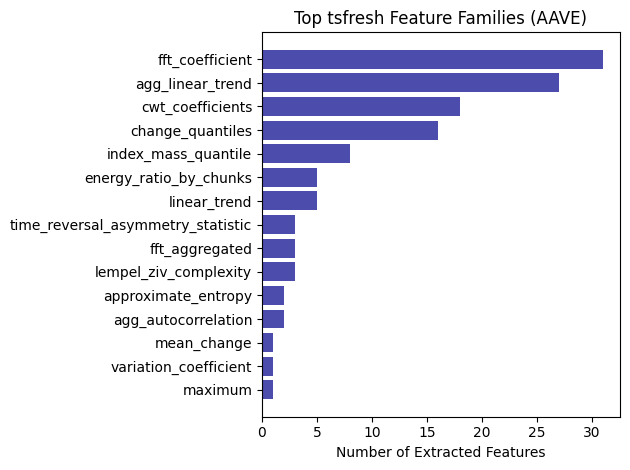

In [164]:
feature_families = []
for col in X_train_selected_svr.columns:
    parts = col.split("__")
    feature_families.append(parts[1] if len(parts) >= 2 else "other")

family_counts = Counter(feature_families)
families, counts = zip(*family_counts.most_common(15))   # top‑15

coverage = (
    df_aave_rolled.groupby("date")["id"]
    .nunique()
    .sort_index()
)

plt.barh(list(families)[::-1], list(counts)[::-1], color="darkblue", alpha=0.7)
plt.title("Top tsfresh Feature Families (AAVE)")
plt.xlabel("Number of Extracted Features")

fig.suptitle("Feature‑Extraction Diagnostics", fontsize=15, y=1.02)
plt.savefig('Plots/5. top features/5. top_features_aave.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### **Step 3:** SVR Train

In [165]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_svr.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_svr.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_svr.diff().shift(-1) < 0).astype(int)

X_train_reg_svr = X_train_selected_svr.copy(); X_train_reg_svr['regime'] = reg_tr
X_wf_reg_svr = X_wf_selected_svr.copy(); X_wf_reg_svr['regime'] = reg_wf
X_test_reg_svr = X_test_selected_svr.copy(); X_test_reg_svr['regime'] = reg_te

In [166]:
def expand_with_regime_interactions(X, reg):
    X_exp = pd.DataFrame(index=X.index)
    # the “global” features:
    X_exp[X.columns] = X
    # bull‑only features (zero in bear)
    X_exp[[f"{c}_bull" for c in X.columns]] = X.values * reg.values[:,None]
    # bear‑only features (zero in bull)
    X_exp[[f"{c}_bear" for c in X.columns]] = X.values * (1 - reg.values)[:,None]
    return X_exp

X_train_int_svr = expand_with_regime_interactions(X_train_selected_svr, reg_tr)
X_wf_int_svr = expand_with_regime_interactions(X_wf_selected_svr, reg_wf)
X_test_int_svr = expand_with_regime_interactions(X_test_selected_svr, reg_te)

In [167]:
svr = SVR(kernel="poly", C=1.0, epsilon=0.1, gamma="scale", degree=2)
svr.fit(X_train_int_svr, y_train_svr)

SVR(degree=2, kernel='poly')

#### **Step 4:** SVR Walk-Forward Validation

In [168]:
# ─── 5) WALK‐FORWARD PREDICTIONS ───────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
start = 0

while start + window_size <= len(X_wf_int_svr):
    idx = X_wf_int_svr.index[start:start+window_size]
    X_win = X_wf_int_svr.loc[idx]
    y_win = y_wf_svr.loc[idx]
    preds = svr.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    # print per‐window metrics
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF window ending at {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")
    start += window_size

WF window ending at 2024-07-06: MAE=0.3407, RMSE=0.6097, MAPE=19.19%, DA=57.14%
WF window ending at 2024-08-25: MAE=0.3168, RMSE=0.4661, MAPE=19.23%, DA=46.94%
WF window ending at 2024-10-14: MAE=0.4489, RMSE=0.7049, MAPE=30.52%, DA=73.47%


#### **Step 5:** Evaluate SVR

In [169]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_svr = svr.predict(X_train_int_svr)
y_test_pred_svr = svr.predict(X_test_int_svr)

# overall test metrics
MAE_train_svr, RMSE_train_svr, MAPE_train_svr, DA_train_svr = calculate_metrics(y_train_svr.values, y_train_pred_svr)
MAE_test_svr, RMSE_test_svr, MAPE_test_svr, DA_test_svr = calculate_metrics(y_test_svr.values, y_test_pred_svr)

print("SVR Train Metrics:")
print(f" MAE={MAE_train_svr:.5f}, RMSE={RMSE_train_svr:.5f}, MAPE={MAPE_train_svr:.2f}%, DA={DA_train_svr:.2f}%")

print("\nSVR Test Metrics:")
print(f" MAE={MAE_test_svr:.5f}, RMSE={RMSE_test_svr:.5f}, MAPE={MAPE_test_svr:.2f}%, DA={DA_test_svr:.2f}%")

SVR Train Metrics:
 MAE=0.27738, RMSE=0.62000, MAPE=16.61%, DA=63.03%

SVR Test Metrics:
 MAE=0.19263, RMSE=0.33479, MAPE=14.75%, DA=51.23%


In [170]:
# 1) WALK‑FORWARD DataFrame
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_svr.values,
    "Predicted": y_test_pred_svr
}, index=X_test_selected_svr.index)

# 3) convert back to days
df_test_day = df_test_results.copy()
df_test_day["Actual_days"]    = np.expm1(df_test_day["Actual"])
df_test_day["Predicted_days"] = np.expm1(df_test_day["Predicted"])
print("\nTest Results (in days):")
print(df_test_day.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-10-28  0.693147   0.831958          1.0        1.297813
2024-10-29  2.079442   1.396772          7.0        3.042129
2024-10-30  1.945910   1.400875          6.0        3.058751
2024-10-31  1.791759   1.504379          5.0        3.501358
2024-11-01  1.609438   1.303332          4.0        2.681544


#### **Step 6:** SVR Plots

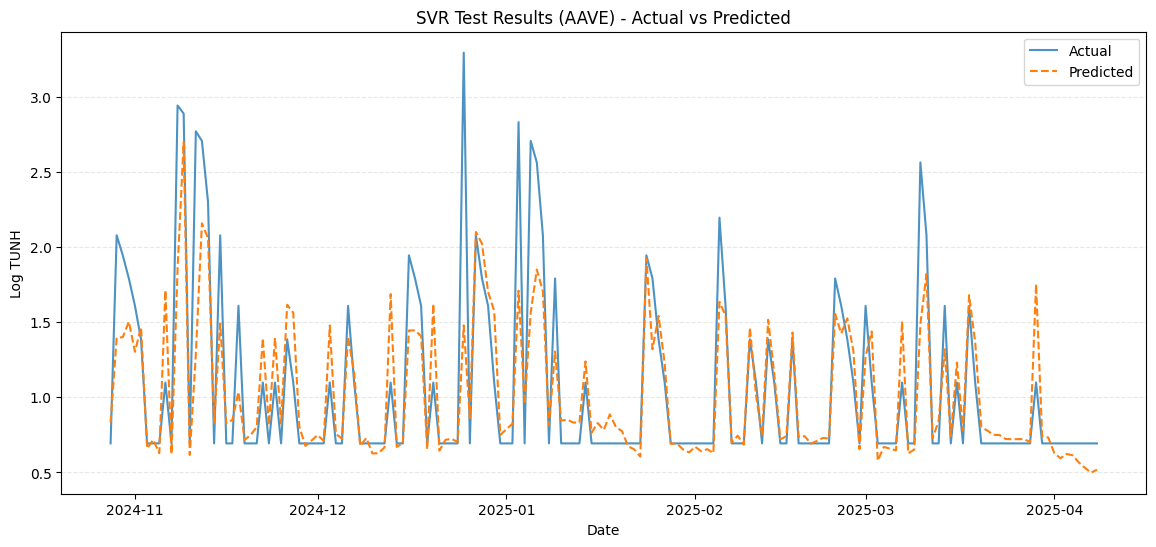

In [171]:
plot_log_results(
    df_test_results,
    "SVR Test Results (AAVE) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/1. svr/5a. test_results_log_aave.png'
)

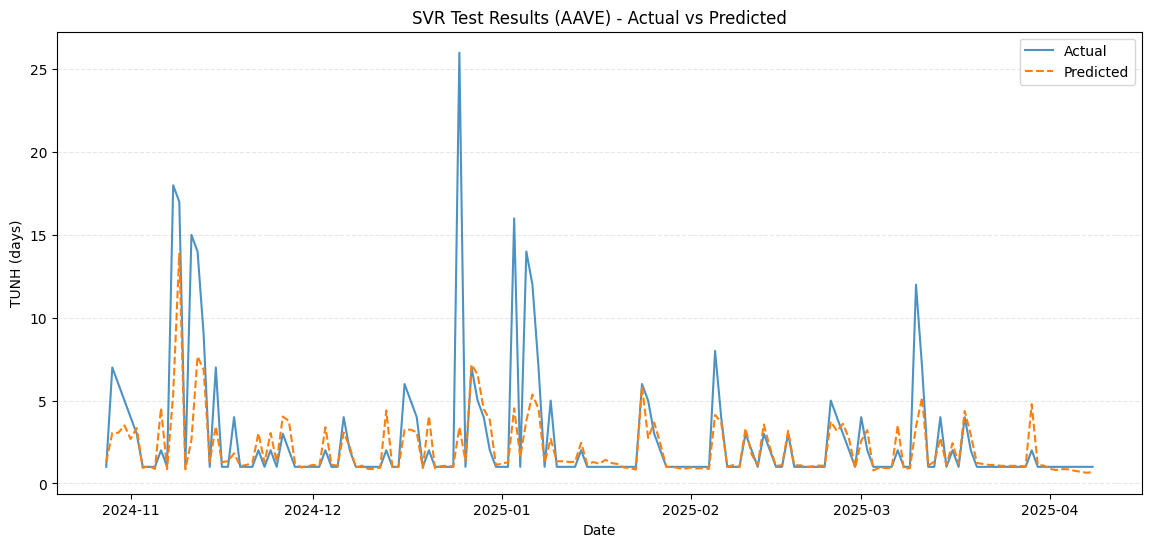

In [172]:
plot_results(
    df_test_day,
    "SVR Test Results (AAVE) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/1. svr/5b. test_results_aave.png'
)

### <span style='color:darkgoldenrod'>**Model 2:** Random Forest Regressor</span>

#### **Step 1:** Split the data for the Random Forest (80% Train - Next 90% Validation - 10% Test)

In [37]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_rf  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_rf  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_rf  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_rf = y.reindex(X_train_rf.index).dropna()
X_train_rf = X_train_rf.loc[y_train_rf.index]
y_wf_rf = y.reindex(X_wf_rf.index).dropna()
X_wf_rf = X_wf_rf.loc[y_wf_rf.index]
y_test_rf = y.reindex(X_test_rf.index).dropna()
X_test_rf = X_test_rf.loc[y_test_rf.index]

#### **Step 2:** Random Forest Feature Selection

In [38]:
selected = select_features(X_train_rf, y_train_rf).columns
X_train_selected_rf = X_train_rf[selected]
X_wf_selected_rf = X_wf_rf[selected]
X_test_selected_rf = X_test_rf[selected]

#### **Step 3:** Random Forest Hyperparameter Tuning

In [39]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_rf.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_rf.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_rf.diff().shift(-1) < 0).astype(int)

X_train_reg_rf = X_train_selected_rf.copy(); X_train_reg_rf['regime'] = reg_tr
X_wf_reg_rf = X_wf_selected_rf.copy(); X_wf_reg_rf['regime'] = reg_wf
X_test_reg_rf = X_test_selected_rf.copy(); X_test_reg_rf['regime'] = reg_te

In [40]:
X_train_int_rf = expand_with_regime_interactions(X_train_selected_rf, reg_tr)
X_wf_int_rf = expand_with_regime_interactions(X_wf_selected_rf, reg_wf)
X_test_int_rf = expand_with_regime_interactions(X_test_selected_rf, reg_te)

In [40]:
# Setup the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search for hyperparameter tuning
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=20, cv=tscv, verbose=2, random_state=42, n_jobs=-1)

#### **Step 4:** Random Forest Training

In [41]:
# Best model
random_search_rf.fit(X_train_int_rf, y_train_rf)
best_rf = random_search_rf.best_estimator_
print("Best parameters for RF with TimeSeriesSplit:", random_search_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   7.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total tim

In [41]:
best_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, bootstrap=True, random_state=42)
# Best model
best_rf.fit(X_train_int_rf, y_train_rf)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

#### **Step 5:** Random Forest Walk-Forward Validation

In [42]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
for start in range(0, len(X_wf_int_rf), window_size):
    idx = X_wf_int_rf.index[start:start+window_size]
    X_win = X_wf_int_rf.loc[idx]
    y_win = y_wf_rf.loc[idx]
    preds = best_rf.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2024-07-06: MAE=0.2855, RMSE=0.5294, MAPE=14.38%, DA=87.76%
WF ending 2024-08-25: MAE=0.2280, RMSE=0.3823, MAPE=11.37%, DA=85.71%
WF ending 2024-10-14: MAE=0.3835, RMSE=0.6334, MAPE=24.95%, DA=89.80%
WF ending 2024-10-27: MAE=0.1730, RMSE=0.3174, MAPE=9.65%, DA=91.67%


#### **Step 6:** Evaluate Random Forest

In [43]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_rf = best_rf.predict(X_train_int_rf)
y_test_pred_rf = best_rf.predict(X_test_int_rf)

# overall test metrics
MAE_train_rf, RMSE_train_rf, MAPE_train_rf, DA_train_rf = calculate_metrics(y_train_rf.values, y_train_pred_rf)
MAE_test_rf, RMSE_test_rf, MAPE_test_rf, DA_test_rf = calculate_metrics(y_test_rf.values, y_test_pred_rf)

print("RF Train Metrics:")
print(f" MAE={MAE_train_rf:.5f}, RMSE={RMSE_train_rf:.5f}, MAPE={MAPE_train_rf:.2f}%, DA={DA_train_rf:.2f}%")

print("\nRF Test Metrics:")
print(f" MAE={MAE_test_rf:.5f}, RMSE={RMSE_test_rf:.5f}, MAPE={MAPE_test_rf:.2f}%, DA={DA_test_rf:.2f}%")

RF Train Metrics:
 MAE=0.22543, RMSE=0.44190, MAPE=12.32%, DA=89.39%

RF Test Metrics:
 MAE=0.16006, RMSE=0.33760, MAPE=10.59%, DA=91.98%


In [44]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_rf.values,
    "Predicted": y_test_pred_rf
}, index=X_test_selected_rf.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-10-28  0.693147   0.693147          1.0        1.000000
2024-10-29  2.079442   2.160241          7.0        7.673232
2024-10-30  1.945910   1.764507          6.0        4.838691
2024-10-31  1.791759   1.476607          5.0        3.378067
2024-11-01  1.609438   1.332801          4.0        2.791648


#### **Step 7:** Random Forest Plots

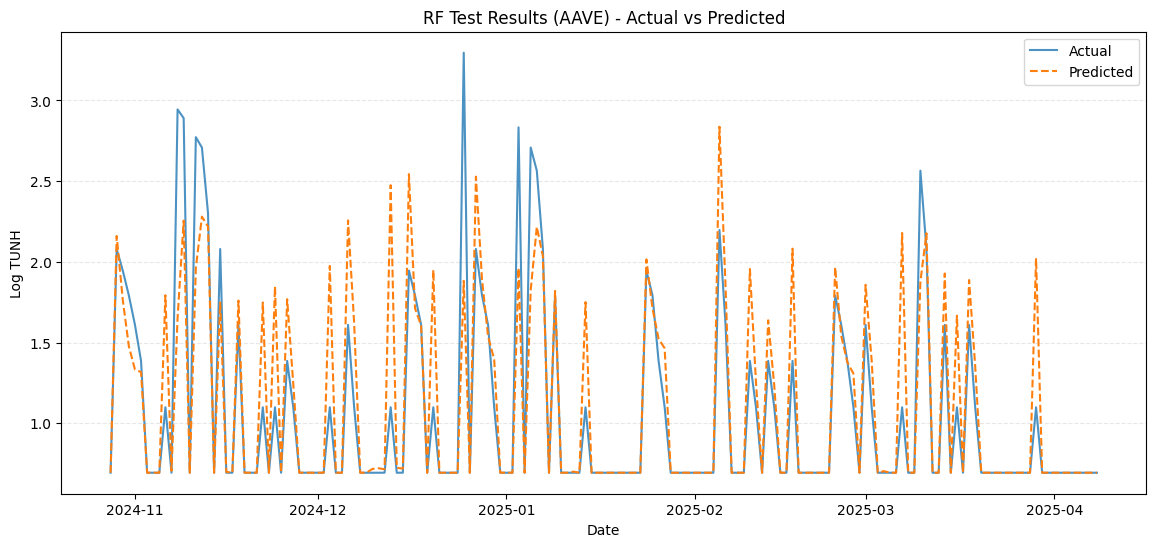

In [45]:
plot_log_results(
    df_test_results,
    "RF Test Results (AAVE) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/2. rf/5a. test_results_log_aave.png'
)

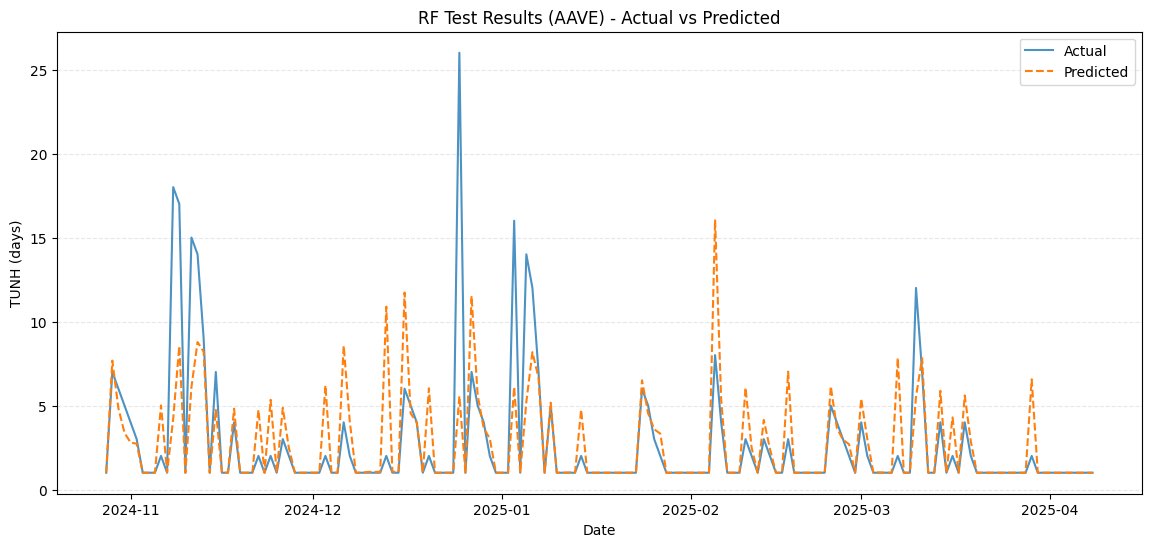

In [46]:
plot_results(
    df_test_days,
    "RF Test Results (AAVE) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/2. rf/5b. test_results_aave.png'
)

### <span style='color:darkgoldenrod'>**Model 3:** XBoost Regressor</span>

#### **Step 1:** Split the data for the XGBoost (80% Train - Next 10% Validation - 10% Test)

In [173]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_xgb  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_xgb  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_xgb  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_xgb = y.reindex(X_train_xgb.index).dropna()
X_train_xgb = X_train_xgb.loc[y_train_xgb.index]
y_wf_xgb = y.reindex(X_wf_xgb.index).dropna()
X_wf_xgb = X_wf_xgb.loc[y_wf_xgb.index]
y_test_xgb = y.reindex(X_test_xgb.index).dropna()
X_test_xgb = X_test_xgb.loc[y_test_xgb.index]

#### **Step 2:** XGBoost Feature Selection

In [174]:
# 2) FEATURE SELECTION
selected = select_features(X_train_xgb, y_train_xgb).columns
X_train_selected_xgb = X_train_xgb[selected]
X_wf_selected_xgb = X_wf_xgb[selected]
X_test_selected_xgb = X_test_xgb[selected]

#### **Step 3:** XGBoost Hyperparameter Tuning

In [175]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_xgb.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_xgb.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_xgb.diff().shift(-1) < 0).astype(int)

X_train_reg_xgb = X_train_selected_xgb.copy(); X_train_reg_xgb['regime'] = reg_tr
X_wf_reg_xgb = X_wf_selected_xgb.copy(); X_wf_reg_xgb['regime'] = reg_wf
X_test_reg_xgb = X_test_selected_xgb.copy(); X_test_reg_xgb['regime'] = reg_te

In [176]:
X_train_int_xgb = expand_with_regime_interactions(X_train_selected_xgb, reg_tr)
X_wf_int_xgb = expand_with_regime_interactions(X_wf_selected_xgb, reg_wf)
X_test_int_xgb = expand_with_regime_interactions(X_test_selected_xgb, reg_te)

In [177]:
# 4) HYPERPARAMETER GRID & TS SPLIT
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
tscv = TimeSeriesSplit(n_splits=5)

# tune bull specialist
search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=20, cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42, n_jobs=-1, verbose=1
)

#### **Step 4:** XGBoost Training

In [178]:
search.fit(X_train_int_xgb, y_train_xgb)
best_xgb = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### **Step 5:** XGBoost Walk-Forward Validation

In [179]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
for start in range(0, len(X_wf_int_xgb), window_size):
    idx = X_wf_int_xgb.index[start:start+window_size]
    X_win = X_wf_int_xgb.loc[idx]
    y_win = y_wf_xgb.loc[idx]
    preds = best_xgb.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2024-07-06: MAE=0.3165, RMSE=0.5905, MAPE=15.41%, DA=85.71%
WF ending 2024-08-25: MAE=0.2419, RMSE=0.4166, MAPE=11.66%, DA=87.76%
WF ending 2024-10-14: MAE=0.3804, RMSE=0.6257, MAPE=24.88%, DA=89.80%
WF ending 2024-10-27: MAE=0.1816, RMSE=0.3090, MAPE=9.75%, DA=91.67%


#### **Step 6:** Evalute XGBoost

In [180]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_xgb = best_xgb.predict(X_train_int_xgb)
y_test_pred_xgb = best_xgb.predict(X_test_int_xgb)

# overall test metrics
MAE_train_xgb, RMSE_train_xgb, MAPE_train_xgb, DA_train_xgb = calculate_metrics(y_train_xgb.values, y_train_pred_xgb)
MAE_test_xgb, RMSE_test_xgb, MAPE_test_xgb, DA_test_xgb = calculate_metrics(y_test_xgb.values, y_test_pred_xgb)

print("XGBoost Train Metrics:")
print(f" MAE={MAE_train_xgb:.5f}, RMSE={RMSE_train_xgb:.5f}, MAPE={MAPE_train_xgb:.2f}%, DA={DA_train_xgb:.2f}%")

print("\nXGBoostTest Metrics:")
print(f" MAE={MAE_test_xgb:.5f}, RMSE={RMSE_test_xgb:.5f}, MAPE={MAPE_test_xgb:.2f}%, DA={DA_test_xgb:.2f}%")

XGBoost Train Metrics:
 MAE=0.08350, RMSE=0.15055, MAPE=4.82%, DA=94.47%

XGBoostTest Metrics:
 MAE=0.16502, RMSE=0.35218, MAPE=10.50%, DA=97.53%


In [181]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_xgb.values,
    "Predicted": y_test_pred_xgb
}, index=X_test_selected_xgb.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-10-28  0.693147   0.692945          1.0        0.999597
2024-10-29  2.079442   2.104470          7.0        7.202751
2024-10-30  1.945910   1.822716          6.0        5.188644
2024-10-31  1.791759   1.579637          5.0        3.853195
2024-11-01  1.609438   1.353243          4.0        2.869954


#### **Step 7:** XGBoost Plots

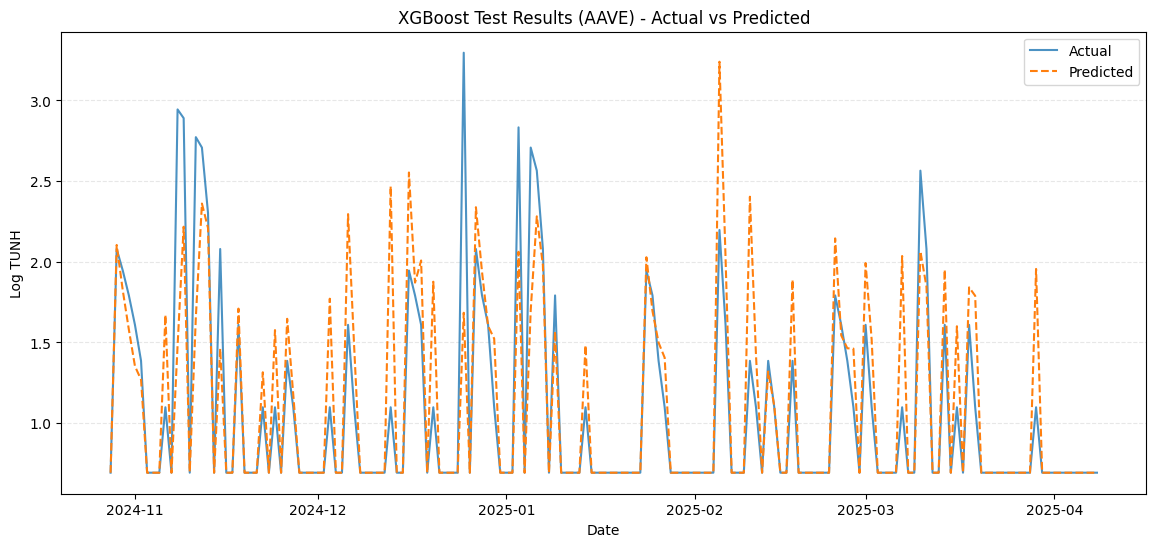

In [182]:
plot_log_results(
    df_test_results,
    "XGBoost Test Results (AAVE) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/3. xgb/5a. test_results_log_aave.png'
)

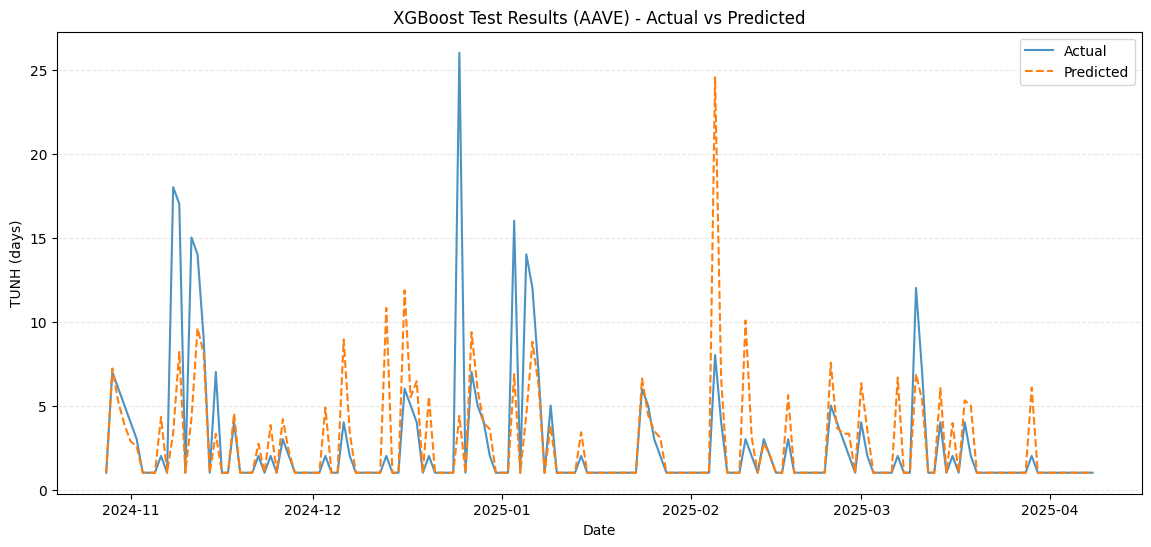

In [183]:
plot_results(
    df_test_days,
    "XGBoost Test Results (AAVE) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/3. xgb/5b. test_results_aave.png'
)

### <span style='color:darkgoldenrod'>**Model 4:** LSTM</span>

#### **Step 1:** Split the data for the LSTM (80% Train - Next 10% Validation - 10% Test)

In [58]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_lstm  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_lstm  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_lstm  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_lstm = y.reindex(X_train_lstm.index).dropna()
X_train_lstm = X_train_lstm.loc[y_train_lstm.index]
y_wf_lstm = y.reindex(X_wf_lstm.index).dropna()
X_wf_lstm = X_wf_lstm.loc[y_wf_lstm.index]
y_test_lstm = y.reindex(X_test_lstm.index).dropna()
X_test_lstm = X_test_lstm.loc[y_test_lstm.index]

#### **Step 2:** LSTM Feature Selection

In [59]:
# 2) FEATURE SELECTION
selected = select_features(X_train_lstm, y_train_lstm).columns
X_train_selected_lstm = X_train_lstm[selected]
X_wf_selected_lstm = X_wf_lstm[selected]
X_test_selected_lstm = X_test_lstm[selected]

#### **Step 3:** LSTM Hyperparameter Tuning

In [60]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_lstm.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_lstm.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_lstm.diff().shift(-1) < 0).astype(int)

X_train_reg_lstm = X_train_selected_lstm.copy(); X_train_reg_lstm['regime'] = reg_tr
X_wf_reg_lstm = X_wf_selected_lstm.copy(); X_wf_reg_lstm['regime'] = reg_wf
X_test_reg_lstm = X_test_selected_lstm.copy(); X_test_reg_lstm['regime'] = reg_te

In [61]:
X_train_int_lstm = expand_with_regime_interactions(X_train_selected_lstm, reg_tr)
X_wf_int_lstm = expand_with_regime_interactions(X_wf_selected_lstm, reg_wf)
X_test_int_lstm = expand_with_regime_interactions(X_test_selected_lstm, reg_te)

In [62]:
# shape vars (from SNIPPET 1+2/3)
n_features = X_train_int_lstm.shape[1]
timesteps  = 1

def lstm_builder(hp):
    model = Sequential()
    model.add(Input(shape=(timesteps, n_features)))
    # first LSTM
    model.add(LSTM(
        units=hp.Int("units1", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float("dropout1", 0.1, 0.5, step=0.1)))
    # optional second LSTM
    if hp.Boolean("stack_second", default=True):
        model.add(LSTM(
            units=hp.Int("units2", min_value=16, max_value=64, step=16),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float("dropout2", 0.1, 0.5, step=0.1)))
    # output
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mean_squared_error"
    )
    return model

In [63]:
# set up tuner
tuner = kt.RandomSearch(
    lstm_builder,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs_aave",
    project_name="aave_lstm_split"
)

# prepare 3D input
X_tr_3d = X_train_int_lstm.values.reshape((-1, timesteps, n_features))
y_tr_arr = y_train_lstm.values

# tune on the entire train set (you could also limit to bull‑slice)
tuner.search(
    X_tr_3d, y_tr_arr,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)]
)

# retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("🔍 Best LSTM hyperparameters:", best_hps.values)

Reloading Tuner from tuner_logs_aave/aave_lstm_split/tuner0.json
🔍 Best LSTM hyperparameters: {'units1': 96, 'dropout1': 0.2, 'stack_second': True, 'units2': 48, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0003286746057803035}


#### **Step 4:** LSTM Training

In [64]:
# rebuild specialists with best_hps
def build_best_lstm():
    model = lstm_builder(best_hps)
    return model

best_lstm = build_best_lstm()

best_lstm.fit(
    X_tr_3d, y_tr_arr,
    epochs=50, batch_size=32,
    callbacks=[EarlyStopping(monitor="loss", patience=3)],
    verbose=1
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2031
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8689
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9345
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8310
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5490
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5413
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5018
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4727
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4106
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3924
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5015
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4032
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3157
Epoch 14/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3562
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3210
Epoch 16/50
41/41 ━

#### **Step 5:** LSTM Walk-Forward Validation

In [65]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
for start in range(0, len(X_wf_int_lstm), window_size):
    # 1) select the window
    idx    = X_wf_int_lstm.index[start:start+window_size]
    X_win  = X_wf_int_lstm.loc[idx]
    y_win  = y_wf_lstm.loc[idx]

    # 2) reshape to (batch, timesteps=1, features)
    X_win_3d = X_win.values.reshape((len(X_win), 1, X_win.shape[1]))

    # 3) predict
    preds = best_lstm.predict(X_win_3d, verbose=0).flatten()

    # 4) store and report
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)

    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, "
        f"MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2024-07-06: MAE=0.5147, RMSE=0.8694, MAPE=24.97%, DA=59.18%
WF ending 2024-08-25: MAE=0.4907, RMSE=0.7270, MAPE=26.45%, DA=42.86%
WF ending 2024-10-14: MAE=0.4745, RMSE=0.7578, MAPE=31.32%, DA=77.55%
WF ending 2024-10-27: MAE=0.1693, RMSE=0.2801, MAPE=10.76%, DA=58.33%


#### **Step 6:** Evaluate LSTM

In [66]:
n_feats = X_train_int_lstm.shape[1]

X_train_int_3d = X_train_int_lstm.values.reshape(
    (len(X_train_int_lstm), 1, n_feats)
)
X_test_int_3d  = X_test_int_lstm.values.reshape(
    (len(X_test_int_lstm), 1, n_feats)
)

# 2) predict and flatten to 1-D
y_train_pred_lstm = best_lstm.predict(X_train_int_3d, verbose=0).flatten()
y_test_pred_lstm  = best_lstm.predict(X_test_int_3d,  verbose=0).flatten()

# 3) compute metrics
MAE_train_lstm, RMSE_train_lstm, MAPE_train_lstm, DA_train_lstm = \
    calculate_metrics(y_train_lstm.values, y_train_pred_lstm)

MAE_test_lstm,  RMSE_test_lstm,  MAPE_test_lstm,  DA_test_lstm  = \
    calculate_metrics(y_test_lstm.values,  y_test_pred_lstm)

# 4) print
print("LSTM Train Metrics:")
print(f" MAE={MAE_train_lstm:.5f}, RMSE={RMSE_train_lstm:.5f}, MAPE={MAPE_train_lstm:.2f}%, DA={DA_train_lstm:.2f}%\n")

print("LSTM Test Metrics:")
print(f" MAE={MAE_test_lstm:.5f}, RMSE={RMSE_test_lstm:.5f}, MAPE={MAPE_test_lstm:.2f}%, DA={DA_test_lstm:.2f}%")

LSTM Train Metrics:
 MAE=0.13096, RMSE=0.23919, MAPE=8.45%, DA=66.87%

LSTM Test Metrics:
 MAE=0.26155, RMSE=0.46590, MAPE=18.87%, DA=48.15%


In [67]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_lstm.values,
    "Predicted": y_test_pred_lstm
}, index=X_test_selected_lstm.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-10-28  0.693147   0.670212          1.0        0.954652
2024-10-29  2.079442   2.769526          7.0       14.951079
2024-10-30  1.945910   1.821670          6.0        5.182171
2024-10-31  1.791759   1.349838          5.0        2.856800
2024-11-01  1.609438   0.840234          4.0        1.316908


#### **Step 7:** LSTM Plots

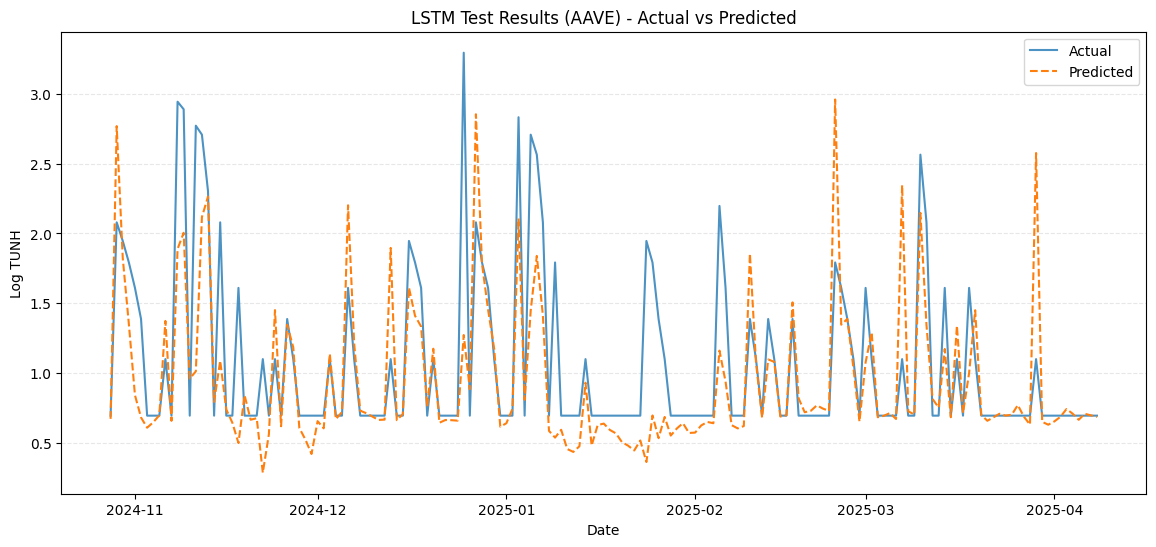

In [68]:
plot_log_results(
    df_test_results,
    "LSTM Test Results (AAVE) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/4. lstm/5a. test_results_log_aave.png'
)

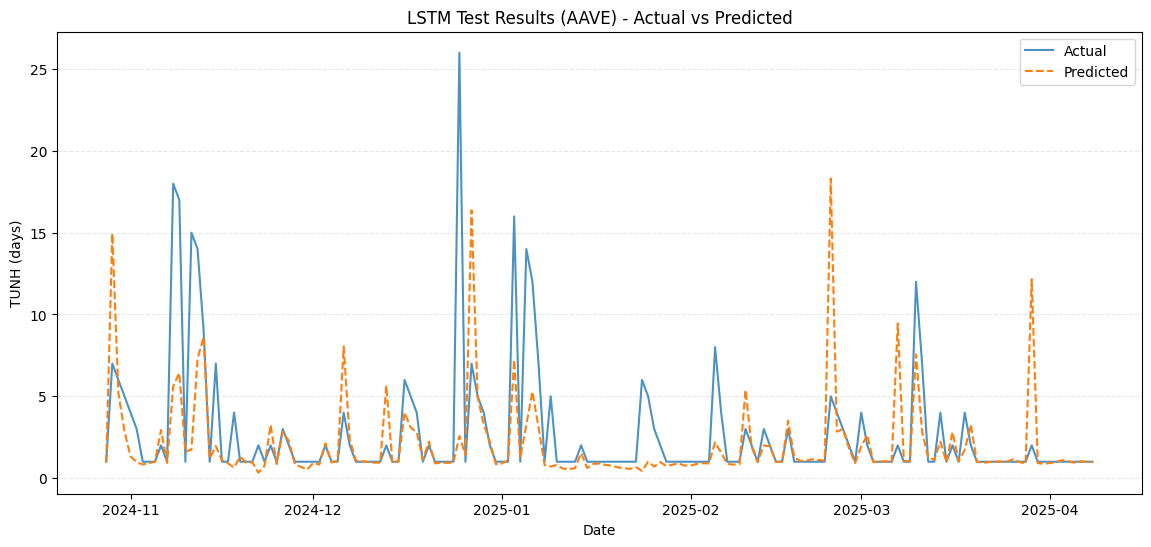

In [69]:
plot_results(
    df_test_days,
    "LSTM Test Results (AAVE) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/4. lstm/5b. test_results_aave.png'
)

### <span style='color:darkgoldenrod'>**Model 5:** MLP</span>

#### **Step 1:** Split the data for the MLP (80% Train - Next 10% Validation - 10% Test)

In [70]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_mlp  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_mlp  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_mlp  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_mlp = y.reindex(X_train_mlp.index).dropna()
X_train_mlp = X_train_mlp.loc[y_train_mlp.index]
y_wf_mlp = y.reindex(X_wf_mlp.index).dropna()
X_wf_mlp = X_wf_mlp.loc[y_wf_mlp.index]
y_test_mlp = y.reindex(X_test_mlp.index).dropna()
X_test_mlp = X_test_mlp.loc[y_test_mlp.index]

#### **Step 2:** MLP Feature Selection

In [71]:
# 2) FEATURE SELECTION
selected = select_features(X_train_mlp, y_train_mlp).columns
X_train_selected_mlp = X_train_mlp[selected]
X_wf_selected_mlp = X_wf_mlp[selected]
X_test_selected_mlp = X_test_mlp[selected]

#### **Step 3:** MLP Build and Train

In [72]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_mlp.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_mlp.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_mlp.diff().shift(-1) < 0).astype(int)

X_train_reg_mlp = X_train_selected_mlp.copy(); X_train_reg_mlp['regime'] = reg_tr
X_wf_reg_mlp = X_wf_selected_mlp.copy(); X_wf_reg_mlp['regime'] = reg_wf
X_test_reg_mlp = X_test_selected_mlp.copy(); X_test_reg_mlp['regime'] = reg_te

In [73]:
X_train_int_mlp = expand_with_regime_interactions(X_train_selected_mlp, reg_tr)
X_wf_int_mlp = expand_with_regime_interactions(X_wf_selected_mlp, reg_wf)
X_test_int_mlp = expand_with_regime_interactions(X_test_selected_mlp, reg_te)

In [74]:
def build_mlp(input_dim, hidden_units=[512,256,128], dropout_rate=0.3, lr=1e-3):
    inp = Input(shape=(input_dim,))
    x = inp
    for h in hidden_units:
        x = Dense(h, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr),
                loss="mean_absolute_error")
    return model

In [75]:
mlp = build_mlp(input_dim=X_train_int_mlp.shape[1])
mlp.fit(X_train_int_mlp.values, y_train_mlp.values,
        validation_data=(X_wf_int_mlp.values, y_wf_mlp.values),
        epochs=50,
        batch_size=32,
        verbose=2)

Epoch 1/50
41/41 - 1s - 21ms/step - loss: 0.7769 - val_loss: 0.4806
Epoch 2/50
41/41 - 0s - 3ms/step - loss: 0.6089 - val_loss: 0.4547
Epoch 3/50
41/41 - 0s - 4ms/step - loss: 0.5593 - val_loss: 0.4126
Epoch 4/50
41/41 - 0s - 4ms/step - loss: 0.5237 - val_loss: 0.4645
Epoch 5/50
41/41 - 0s - 4ms/step - loss: 0.5208 - val_loss: 0.4145
Epoch 6/50
41/41 - 0s - 4ms/step - loss: 0.4722 - val_loss: 0.5252
Epoch 7/50
41/41 - 0s - 4ms/step - loss: 0.4416 - val_loss: 0.4802
Epoch 8/50
41/41 - 0s - 4ms/step - loss: 0.4461 - val_loss: 0.4340
Epoch 9/50
41/41 - 0s - 4ms/step - loss: 0.4412 - val_loss: 0.4101
Epoch 10/50
41/41 - 0s - 4ms/step - loss: 0.4380 - val_loss: 0.4522
Epoch 11/50
41/41 - 0s - 4ms/step - loss: 0.4193 - val_loss: 0.3667
Epoch 12/50
41/41 - 0s - 4ms/step - loss: 0.4126 - val_loss: 0.4698
Epoch 13/50
41/41 - 0s - 4ms/step - loss: 0.4097 - val_loss: 0.4366
Epoch 14/50
41/41 - 0s - 4ms/step - loss: 0.4125 - val_loss: 0.5100
Epoch 15/50
41/41 - 0s - 4ms/step - loss: 0.4239 - val_l

#### **Step 4:** MLP Walk-Forward Validation

In [76]:
window_size = 50
wf_preds, wf_actuals, wf_indices = [], [], []
for start in range(0, len(X_wf_int_mlp), 50):
    idx = X_wf_int_mlp.index[start:start+window_size]
    end = min(start+50, len(X_wf_int_mlp))
    p = mlp.predict(X_wf_int_mlp.values[start:end]).flatten()
    wf_preds.append(p)
    wf_actuals.append(y_wf_mlp.values[start:end])
    wf_indices.append(idx)
    MAE_wf, RMSE_wf, MAPE_wf, DA_wf = calculate_metrics(np.concatenate(wf_actuals), 
                                                        np.concatenate(wf_preds))
    print(f"WF ending {X_wf_int_mlp.index[end-1]}: MAE={MAE_wf:.4f}, RMSE={RMSE_wf:.4f}, MAPE={MAPE_wf:.2f}%, DA={DA_wf:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
WF ending 2024-07-06: MAE=0.4128, RMSE=0.7637, MAPE=16.91%, DA=77.55%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
WF ending 2024-08-25: MAE=0.4351, RMSE=0.7539, MAPE=18.94%, DA=77.78%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
WF ending 2024-10-14: MAE=0.4476, RMSE=0.7725, MAPE=21.87%, DA=80.54%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
WF ending 2024-10-27: MAE=0.4276, RMSE=0.7458, MAPE=21.11%, DA=80.86%


#### **Step 5:** Evaluate MLP

In [78]:
y_train_pred_mlp = mlp.predict(X_train_int_mlp.values).flatten()
y_test_pred_mlp = mlp.predict(X_test_int_mlp.values).flatten()

MAE_train_mlp, RMSE_train_mlp, MAPE_train_mlp, DA_train_mlp = \
    calculate_metrics(y_train_mlp.values, y_train_pred_mlp)
MAE_test_mlp, RMSE_test_mlp, MAPE_test_mlp, DA_test_mlp = \
    calculate_metrics(y_test_mlp.values, y_test_pred_mlp)

print("MLP Train Metrics:")
print(f" MAE={MAE_train_mlp:.5f}, RMSE={RMSE_train_mlp:.5f}, MAPE={MAPE_train_mlp:.2f}%, DA={DA_train_mlp:.2f}%\n")

print("MLP Test Metrics:")
print(f" MAE={MAE_test_mlp:.5f}, RMSE={RMSE_test_mlp:.5f}, MAPE={MAPE_test_mlp:.2f}%, DA={DA_test_mlp:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MLP Train Metrics:
 MAE=0.24549, RMSE=0.51254, MAPE=11.05%, DA=88.16%

MLP Test Metrics:
 MAE=0.20167, RMSE=0.39535, MAPE=11.89%, DA=86.42%


In [79]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(wf_actuals),
    "Predicted": np.concatenate(wf_preds)
}, index=pd.DatetimeIndex(np.concatenate(wf_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_mlp.values,
    "Predicted": y_test_pred_mlp
}, index=X_test_selected_mlp.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-10-28  0.693147   0.679027          1.0        0.971959
2024-10-29  2.079442   1.983828          7.0        6.270518
2024-10-30  1.945910   1.354900          6.0        2.876372
2024-10-31  1.791759   1.512749          5.0        3.539193
2024-11-01  1.609438   0.915197          4.0        1.497267


#### **Step 6:** MLP Plots

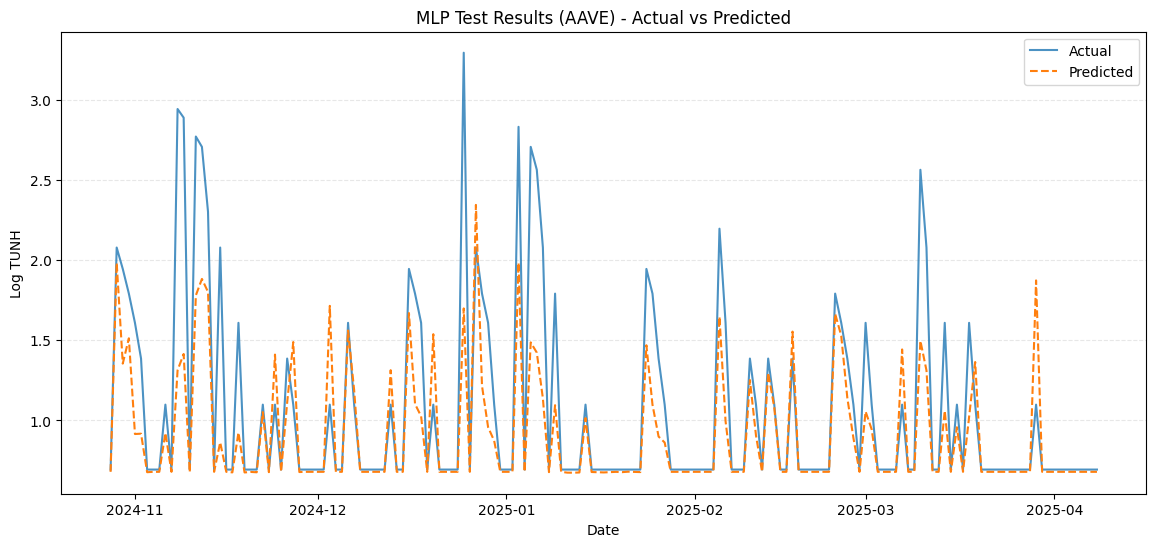

In [80]:
plot_log_results(
    df_test_results,
    "MLP Test Results (AAVE) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/5. mlp/5a. test_results_log_aave.png'
)

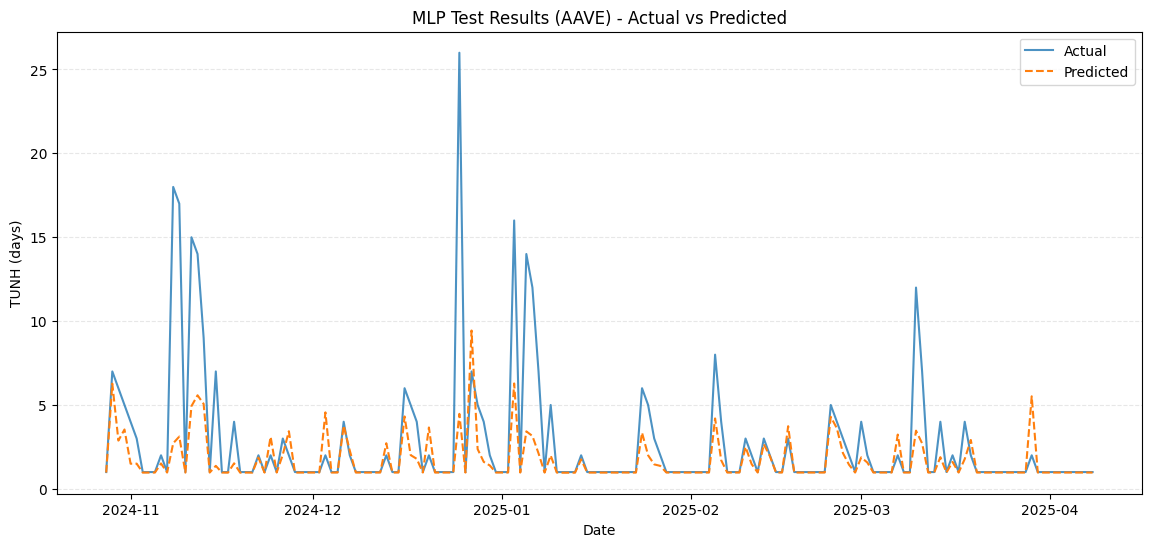

In [81]:
plot_results(
    df_test_days,
    "MLP Test Results (AAVE) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/5. mlp/5b. test_results_aave.png'
)

## <span style='color:brown'>**Stage C:** Comparison</span>

In [82]:
# Final metrics
model_names = ['SVR', 'Random Forest', 'XGBoost', 'LSTM', 'MLP']

train_rmse = [RMSE_train_svr, RMSE_train_rf, RMSE_train_xgb, RMSE_train_lstm, RMSE_train_mlp]
test_rmse = [RMSE_test_svr, RMSE_test_rf, RMSE_test_xgb, RMSE_test_lstm, RMSE_test_mlp]

train_mae = [MAE_train_svr, MAE_train_rf, MAE_train_xgb, MAE_train_lstm, MAE_test_mlp]
test_mae = [MAE_test_svr, MAE_test_rf, MAE_test_xgb, MAE_test_lstm, MAE_test_mlp]

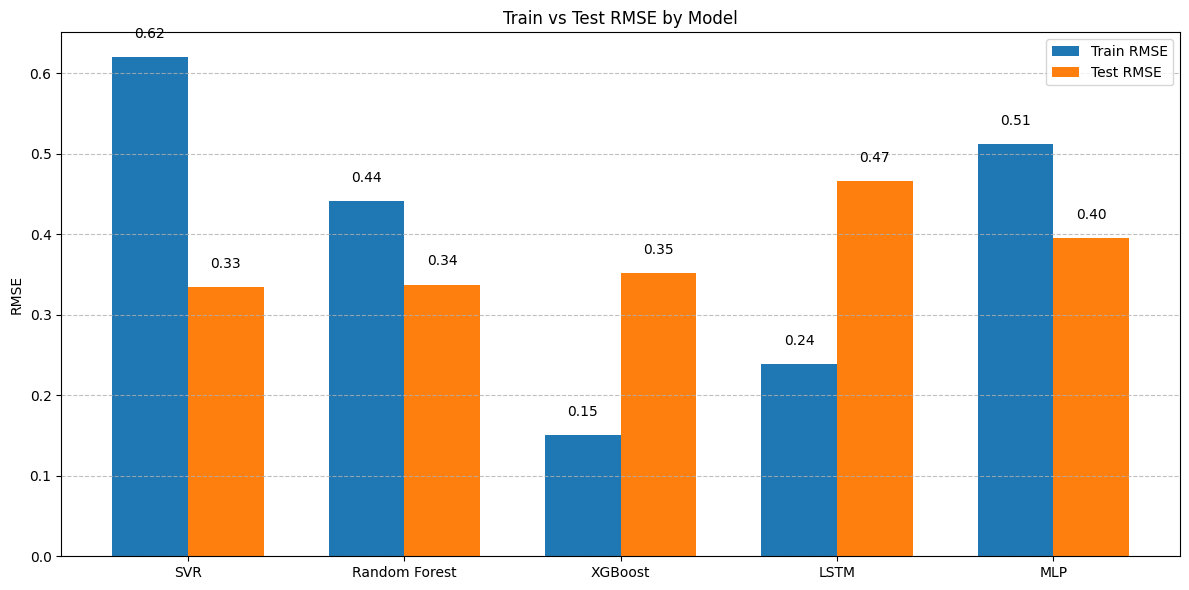

In [83]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
bars2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

ax.set_ylabel('RMSE')
ax.set_title('Train vs Test RMSE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/5a. summary_rmse_aave.png', dpi=300)

plt.tight_layout()
plt.show()

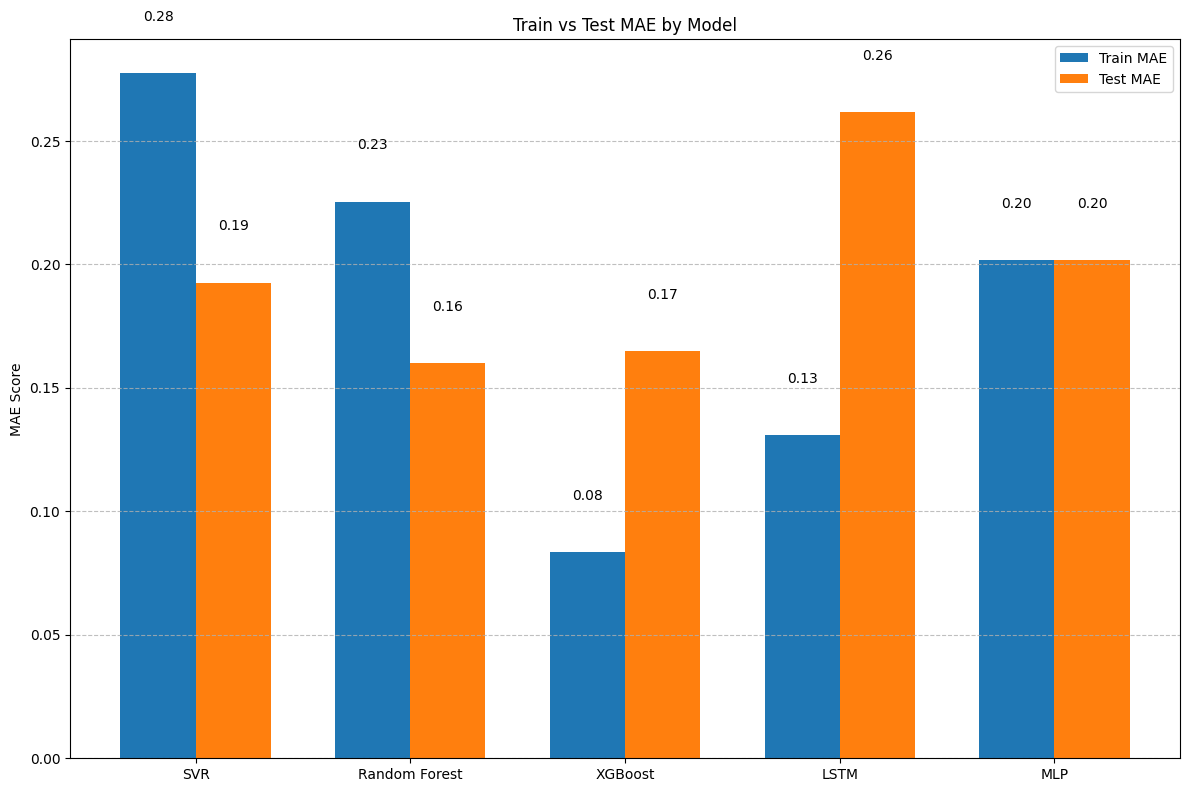

In [84]:
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, train_mae, width, label='Train MAE')
bars2 = ax.bar(x + width/2, test_mae, width, label='Test MAE')

ax.set_ylabel('MAE Score')
ax.set_title('Train vs Test MAE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/5b. summary_mae_aave.png', dpi=300)
plt.tight_layout()
plt.show()

# **RQ2:** Feature Selection & Interpretability

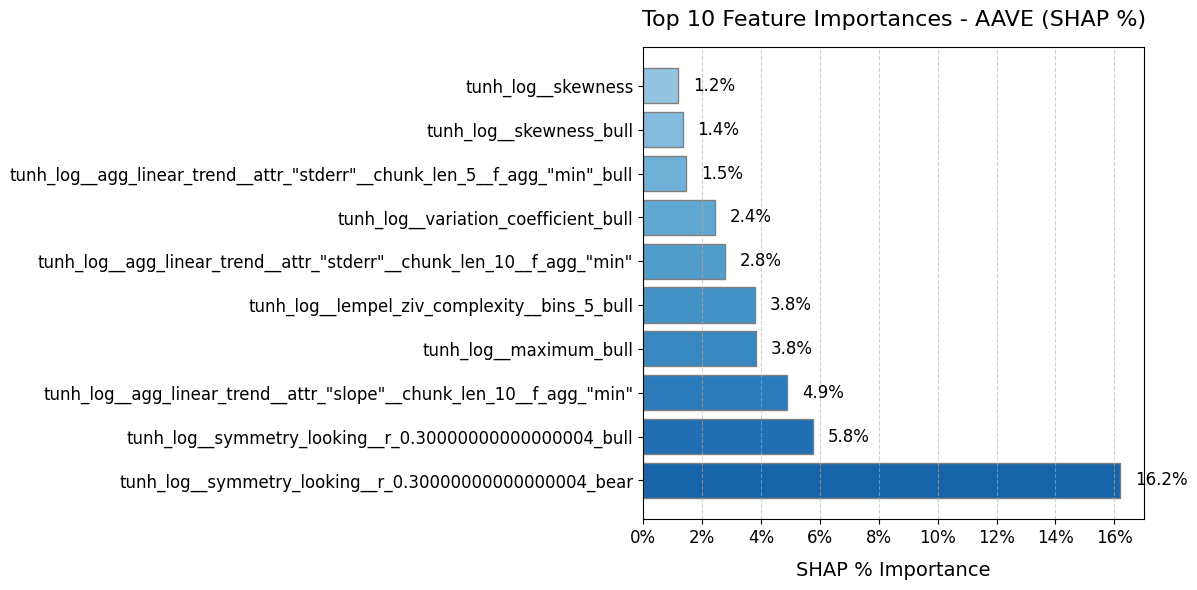

In [184]:
# 1) build a TreeExplainer
explainer = shap.TreeExplainer(best_xgb)

# 2) get SHAP values for your training set
#    (for regression single‐output model this returns a (n_samples, n_features) array)
shap_vals = explainer.shap_values(X_train_int_xgb)

# 3) mean absolute per feature
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_imp = pd.Series(mean_abs_shap, index=X_train_int_xgb.columns)

# 4) to percentages
shap_imp_pct = 100 * shap_imp / shap_imp.sum()

# 5) top 10
top10_shap = shap_imp_pct.sort_values(ascending=False).head(10)

# 6) plot
features = top10_shap.index.tolist()
values   = top10_shap.values

# reverse for barh (so largest at top)
features = features[::-1]
values   = values[::-1]

# build a blue gradient
cmap = plt.get_cmap("Blues")
colors = cmap(np.linspace(0.4, 0.8, len(values)))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(features, values, color=colors, edgecolor="gray")

# add annotations
for bar, val in zip(bars, values):
    ax.text(
        bar.get_width() + 0.5,               # x position: a little right of bar
        bar.get_y() + bar.get_height() / 2,  # y position: center of bar
        f"{val:.1f}%", 
        va="center", 
        fontsize=12
    )

# styling
ax.set_xlabel("SHAP % Importance", fontsize=14, labelpad=10)
ax.set_title("Top 10 Feature Importances - AAVE (SHAP %)", fontsize=16, pad=15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0f}%")
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # largest on top

# tick params
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(axis="x", labelsize=12)

plt.savefig('Plots/8. feature importance/5. shap_xgb_aave.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()